# Phase Lock Loop

This PLL is based on [this SDR PLL](http://liquidsdr.org/blog/pll-howto/) coded in C. Once this is working we will expand it to a more complex Costas Loop.

## Initialization of variables

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Initializations

phi_hat = 0.3     # phi_hat is the output phase 
freq_offset = 0.3
delta_phi = 0.0    # delta_phi is the phase difference between the incomming signal and the NCO
wn = 0.01          # wn is omega_n, pll bandwidth
zeta = 0.707       # Damping factor of the loop
K = 1000           # K = loop gain, which I assume can be chosen, but this is a sample value
N = 1000           # Number of samples

noise_power = 1
noise_mean = 0

# These are just initializing some vectors for plotting
ref = np.linspace(0, N, N)



## Generate a sine wave to test with

This block generates a simple sine wave which is set by the phi and freq_offset parameters. 

In [9]:
phi = 0.0              # Original signal phase
def tstSignalGen(ref, phi, freq_offset):
    signal = []       # Save the signal_in for plotting
    for i in ref:

        # Complex input signal
        signal_in = np.cos(phi) + 1j*np.sin(phi)
        phi += freq_offset

        signal.append(signal_in) # Saved for plotting
    return signal

## Phase lock to input signal

This function takes a complex signal, and attempts to lock to it. It is currently only useful for example purposes.

The ax, tx, and bx variables are for the loop parameters. Using feedback theory I derived (ok, I stole) an equation in the form 

$\frac{b_0 z^{-1} + b_1 z^{-1} + b_2 z^{-1}}{a_0 z^{-1} + a_1 z^{-1} + a_2 z^{-1}}$

tx are just other ways of expressing the variables wn, zeta, and K. In standard form ${a_0 z^{-1} = 1}$, but here it was left in variable form and the variable assigned to be 1.

In [10]:
def phaseLock(signal, phi_hat, delta_phi):
    # Input should be a complex signal
    
    
    output = []            # Save the signal_out for plotting
    
    # Clear buffers
    v0 = 0.0           
    v1 = 0.0           
    v2 = 0.0      
    
    #Set parameters for feedback equation above
    a0 = 1.0
    a1 = -2.0
    a2 = 1.0

    t1 = K/(wn*wn)     # tau_1
    t2 = 2*zeta/wn     # tau_2

    b0 = (4*K/t1) * (1.0+t2/2.0)
    b1 = 8*K/t1
    b2 = (4*K/t1) * (1.0-t2/2.0)

    for sample in signal:

        # Complex oscillator signal
        nco = np.cos(phi_hat) + 1j*np.sin(phi_hat)

        delta_phi = np.angle( sample * np.conj( nco))
        output.append(nco)

        # vx varibles are a buffer to store output changes on transfer function variables ax and bx
        v2 =  v1
        v1 =  v0
        v0 =  delta_phi - v1 * a1 - v2 * a2
        phi_hat =  v0 * b0 + v1 * b1 + v2* b2
    return output



In [11]:
noise = np.random.normal(noise_mean, noise_power, N)
inputsignal = np.array(tstSignalGen(ref, phi, freq_offset)) + noise
lockedsig = phaseLock(inputsignal, phi_hat, delta_phi)

# Plot real & imaginary outputs

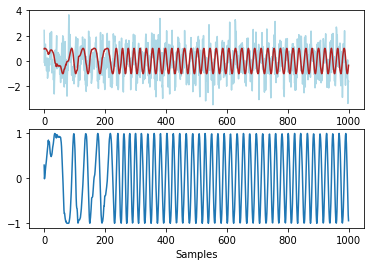

In [12]:

plt.subplot(2, 1, 1)
plt.plot(ref, np.real(inputsignal), color = 'lightblue')
plt.plot(ref, np.real(lockedsig), color = 'firebrick')



plt.subplot(2, 1, 2)
plt.plot(ref, np.imag(lockedsig))
plt.xlabel("Samples")

#plt.ylabel("Amplitude")
plt.show()

## 2 signal comparison

Tested 2 different signals for direct comparison

In [13]:
in1 = tstSignalGen(ref, 0.0, 0.4)
in2 = tstSignalGen(ref, 0.0, 0.09)

lock1 = phaseLock(in1, phi_hat, delta_phi)
lock2 = phaseLock(in2, phi_hat, delta_phi)

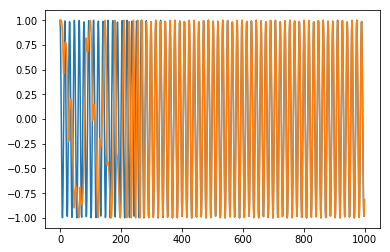

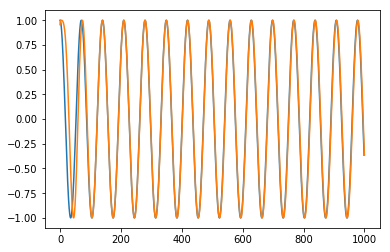

In [14]:
plt.plot(np.real(in1))
plt.plot(np.real(lock1))
plt.show()
plt.plot(np.real(in2))
plt.plot(ref, np.real(lock2))
plt.show()

